In [96]:
import pandas as pd
from pathlib import Path
import sys
import torch




sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

population_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\data"
)

# Model

Define the NN architecture.

It's a simple feed-foward linear NN with a single hidden layer.
Adapted from [here](https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb).


In [97]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()

            self.input_size = input_size
            self.hidden_size  = hidden_size

            self.relu = torch.nn.ReLU()
            
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.tanh = torch.nn.Tanh()        
            
        def forward(self, x):
            hidden = self.fc1(x)
            # hidden = self.tanh(hidden)
            output = self.fc2(hidden)
            # output = self.tanh(output)
            return output

## Load data

In [98]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = pd.read_parquet(population_cache / "FC_220434_BAA1101192_hairpin.parquet")

# average every 5 frames
df = df.groupby(df.index // 5).mean()

# remove rows with nans
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)



In [99]:
df.columns[:30]

Index(['index', 's', 'apex_distance', 'v', 'dv_250ms', 'dv_500ms', 'dv_1000ms',
       'omega', 'domega_250ms', 'domega_500ms', 'domega_1000ms', 'curv_0cm',
       'curv_5cm', 'curv_10cm', 'curv_15cm', 'curv_20cm', 'curv_25cm',
       'curv_30cm', '648', '438', '440', '447', '448', '455', '462', '294',
       '432', '584', '596', '600'],
      dtype='object')

In [133]:
VAR = "curv_15cm"
units = [c for c in df.columns[18:] if "shuffle" not in c]
# shuffled_units = [c+"_shuffle_1" for c in units]

X = df[units].values
Y = df[VAR].values


# normalize
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y.reshape(-1, 1))

In [134]:
# split between training and test set
from sklearn.model_selection import train_test_split

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.33)

## Training

In [135]:
n_units = len(units)
n_hidden = 1
n_epochs = 2500

criterion = torch.nn.MSELoss()


In [136]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
models = dict()


for n_hidden in range(5):
    model = Feedforward(n_units, n_hidden+1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    model.train()  # enter training mode

    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_train)

        # compute loss
        loss = criterion(y_pred, y_train)
        
        # backward pass
        loss.backward()
        optimizer.step()

    models[n_hidden] = model
    print(f"N hidden {n_hidden}: loss {loss.item()}")


    

N hidden 0: loss 0.8371919989585876
N hidden 1: loss 0.8354250192642212
N hidden 2: loss 0.8352903723716736
N hidden 3: loss 0.8351845741271973
N hidden 4: loss 0.8351373672485352


## Evaluate

In [137]:
X = df[units].values
Y = df[VAR].values


# normalize
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y.reshape(-1, 1))

X = torch.Tensor(X)
Y = torch.Tensor(Y)



N hidden 0: pearson 0.3751116307452832
N hidden 4: pearson 0.37659123482534895


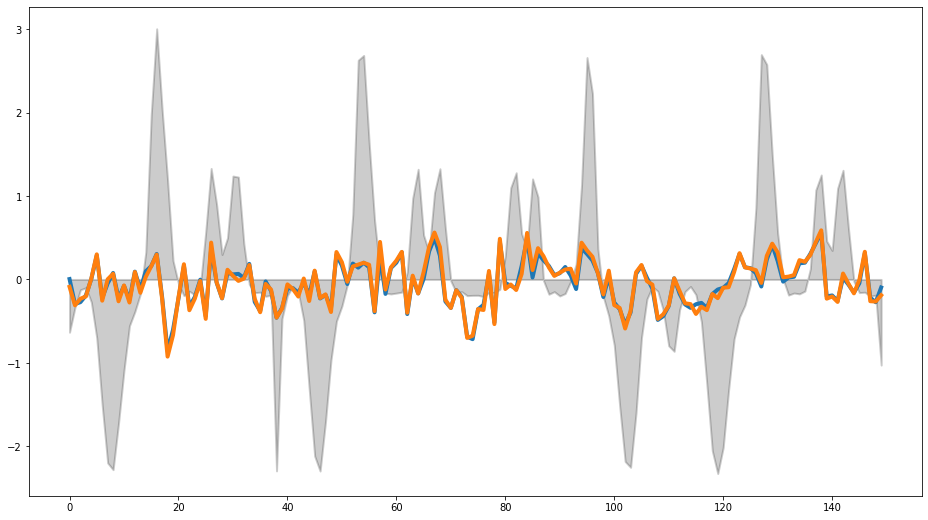

In [138]:
# model.cpu()
# model.eval()
# y_pred = model(X_test)
# after_train = criterion(y_pred, y_test) 
# print('Test loss after training' , after_train.item())

from scipy.stats import pearsonr

y = Y.detach().numpy()


import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(16, 9))
plt.fill_between(np.arange(150), y[:150].ravel(), 0, lw=2, alpha=.2, color="k")


for nh in (0, 4):
    model = models[nh]
    model.eval()
    model.cpu()
    
    yhat = model(X)
    yhat = yhat.squeeze().detach().numpy()
    print(f"N hidden {nh}: pearson {pearsonr(y.ravel(), yhat.ravel())[0]}")
    plt.plot(yhat[:150], lw=4)